<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Trashcan-data-set" data-toc-modified-id="Load-Trashcan-data-set-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Trashcan data set</a></span></li><li><span><a href="#Definition-of-the-Dataloader-and-the-model" data-toc-modified-id="Definition-of-the-Dataloader-and-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Definition of the Dataloader and the model</a></span></li><li><span><a href="#Definition-of-the-Faster-RCNN" data-toc-modified-id="Definition-of-the-Faster-RCNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Definition of the Faster RCNN</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

This notebook aims to train a Faster RCNN from scratch.

In [ ]:
!pip install pycocotools torch torchvision

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches #In order to draw the box ! (je sais pas pourquoi j'écris en anglais)
from torchvision import models
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torchvision
import pycocotools
import copy
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from torchvision import datasets
from torch.utils.data import DataLoader

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

CUDA_LAUNCH_BLOCKING=1.

## Load Trashcan data set 

In [3]:
#In order to download the dataset
!wget "https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y"
!unzip "dataset.zip?sequence=12&isAllowed=y"

# The directory containing the source images
data_path = "dataset/instance_version/train"
valid_path = "dataset/instance_version/val"
# The path to the COCO labels JSON file
labels_path = "dataset/instance_version/instances_train_trashcan.json"
labels_test = "dataset/instance_version/instances_val_trashcan.json"

We used a ResNet 50 trained on ImageNet. This model was available on Pytorch. 
For FastRCNN we decided to remove the three last layers of the ResNet in order to get feature maps of size (50,50) (roughly as in the original paper).

Notice that we put `models.resnet50(pretrained = False)` : we took the structure of the ResNet 50 but the weight are initialized randomly.

In [6]:
from torchvision import models

resnet50_scratch = models.resnet50(pretrained=False)
image_torch = 800*torch.rand((1,3,800,800))
#We choose the place where we extracted the feature map in order to get H_feature * W_feature around 2400 (papers)
resnet50_features = nn.Sequential(*(list(resnet50.children())[:-3]))
resnet50_features(image_torch).shape

torch.Size([1, 1024, 50, 50])

## Definition of the Dataloader and the model

In [7]:
#Attention "bbox": [x,y,width,height]
class CocoDetection_diy_bis(data.Dataset) :
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        resize : (int,int) size of the images wanted 
    """

    def __init__(self, root, annFile, size):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.total_ids = list(self.coco.imgs.keys())
        self.ids = [self.total_ids[j] for j in range(len(self.total_ids))]
        self.size = size
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        # Resize des images :
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        original_size = img.size
        img = self.transform(img)

        # Targets dict :
        targets = {'labels':[],'boxes':[], 'area':[]}

        for elem in target :  
          box = np.copy(elem['bbox'])
          box[0] *= self.size[0] / original_size[0]
          box[1] *= self.size[1] / original_size[1]
          box[2] *= self.size[0] / original_size[0]
          box[3] *= self.size[1] / original_size[1]
          
          new_box = np.copy(elem['bbox'])
          new_box[0] = box[0]
          new_box[1] = box[1] 
          new_box[2] = box[0] + (box[2])
          new_box[3] = box[1] + (box[3])
          area_computed = (new_box[3] - new_box[1])*(new_box[2] - new_box[0])
          targets['boxes'].append(new_box)
          targets['area'].append(area_computed)
          targets['labels'].append(elem['category_id']) # because 0 will be for background
        targets['labels'] = torch.from_numpy(np.array(targets["labels"])).to(torch.int64) 
        targets["iscrowd"] = torch.zeros(len(targets['area']))
        targets['area'] = torch.from_numpy(np.array(targets["area"]))
        if(len(targets["boxes"]) > 0):
            targets["boxes"] = torch.from_numpy(np.vstack(targets["boxes"]))
        else:
            targets["boxes"] = torch.Tensor([])
        
        return img, targets
        


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
instances_train = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224))
instances_train_dataloader = DataLoader(instances_train, batch_size=4, shuffle=True,collate_fn = collate_fn)

instances_valid = CocoDetection_diy_bis(root = valid_path, annFile = labels_test, size=(224,224))
instances_valid_dataloader = DataLoader(instances_valid, batch_size=4, shuffle=True,collate_fn = collate_fn)

loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


## Definition of the Faster RCNN

We decided to take the same anchors size and ratios as proposed in the original paper except we had extra ones.

In [11]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = resnet50_features

backbone.out_channels = 1024


anchor_generator = AnchorGenerator(sizes=((4,8,16,32,64),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))


roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes= 23,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

As described in the paper, the optimisation is done using SGD algorithm with momentum (0.9) and a learning rate at 0.001.

In [12]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

from torch import optim
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

Unlike DETR, we trained it on only 30 epoches because of the computationnal cost.

In [ ]:
total_train_loss = []
total_val_loss = []

N_EPOCH = 30
for epoch in range(N_EPOCH):
    train_loss = []
    val_loss = []
    model.train()
    for images, targets in instances_train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        ind_to_remove = [i for i in range(len(targets)) if targets[i]["labels"].shape == torch.Size([0])]
        #memove when empty
        images = [images[i] for i in range(len(images)) if not(i in ind_to_remove)]
        targets = [targets[i] for i in range(len(targets)) if not(i in ind_to_remove)]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    with torch.no_grad():
        for images, targets in instances_valid_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            ind_to_remove = [i for i in range(len(targets)) if targets[i]["labels"].shape == torch.Size([0])]
            #memove when empty
            images = [images[i] for i in range(len(images)) if not(i in ind_to_remove)]
            targets = [targets[i] for i in range(len(targets)) if not(i in ind_to_remove)]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss.append(losses.item())
    epoch_val_loss = np.mean(val_loss)
    total_val_loss.append(epoch_val_loss)
    if(epoch_val_loss == min(total_val_loss)):
        best_model = copy.deepcopy(model.state_dict())

/usr/local/lib/python3.6/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Evaluation

In [15]:
eval = np.vstack([np.array(total_train_loss),np.array(total_val_loss)])

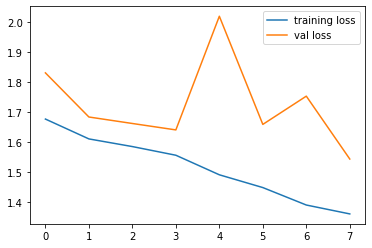

In [16]:
plt.plot(range(len(eval[0,:])), eval[0,:], label = "training loss"),
plt.plot(range(len(eval[0,:])), eval[1,:], label = "val loss"),
plt.legend()